In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch 
import numpy as np
import ase 
from ase.io import read
import json  
from ase.units import Hartree

In [3]:
torch.set_default_dtype(torch.float64) # set default dtype of torch to avoid numerical errors 

In [4]:
device = "cpu"

# Instantiate the Molecule Dataset 

In [5]:
from mlelec.data.dataset import MoleculeDataset

/home/suman/miniconda3/envs/qm7/lib/python3.11/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [6]:
molecule_data = MoleculeDataset(
    mol_name = "qm7",
    use_precomputed=True,
    path= "examples/data/qm7",
    aux_path="examples/data/qm7/sto-3g",
    frame_slice=slice(0, 1000),
    device=device,
    aux=["overlap", "orbitals"],
    target=["fock", "dipole_moment"],
)

Loading structures
examples/data/qm7/sto-3g/fock.hickle
examples/data/qm7/sto-3g/dipole_moment.hickle


### Create the ML dataset from the molecular data 

In [7]:
from mlelec.data.dataset import MLDataset

In [9]:
ml_data = MLDataset(
    molecule_data=molecule_data,
    device=device,
    model_strategy="coupled",
    shuffle=True, 
    shuffle_seed=1234,
)

In [10]:
ml_data._split_indices(train_frac=0.7, val_frac=0.2, test_frac=0.1)

In [11]:
from mlelec.features.acdc import compute_features_for_target
from mlelec.data.dataset import get_dataloader

In [12]:
hypers = {
            "cutoff": 3.0,
            "max_radial" : 6,
            "max_angular": 4,
            "atomic_gaussian_width": 0.3,
            "center_atom_weight": 1,
            "radial_basis": {"Gto": {}},
            "cutoff_function": {"ShiftedCosine": {"width": 0.1}},
        }
hypers_pair = {
            "cutoff": 4.0,
            "max_radial" : 6,
            "max_angular": 4,
            "atomic_gaussian_width": 0.3,
            "center_atom_weight": 1,
            "radial_basis": {"Gto": {}},
            "cutoff_function": {"ShiftedCosine": {"width": 0.1}},
        }

ml_data._set_features(compute_features_for_target(ml_data, device = device, hypers = hypers, hypers_pair = hypers_pair))

In [13]:
train_dl, val_dl, test_dl = get_dataloader(ml_data, model_return="blocks", batch_size=50)

In [14]:
import metatensor
from metatensor import Labels

# Helper function to drop blocks in the train, validation and test subset that have zero samples due to splitting of the dataset

def drop_zero_blocks(train_tensor, val_tensor, test_tensor):
    for i1,b1 in train_tensor.items():
        if b1.values.shape[0] == 0:
            train_tensor = metatensor.drop_blocks(train_tensor, Labels(i1.names, i1.values.reshape(1,-1)))
            
    for i2,b2 in val_tensor.items():
        if b2.values.shape[0] == 0:
            val_tensor = metatensor.drop_blocks(val_tensor, Labels(i2.names, i2.values.reshape(1,-1)))
            
    for i3,b3 in test_tensor.items():
        if b3.values.shape[0] == 0:
            test_tensor = metatensor.drop_blocks(test_tensor, Labels(i3.names, i3.values.reshape(1,-1)))
            
    return train_tensor, val_tensor, test_tensor

In [15]:
ml_data.target_train, ml_data.target_val, ml_data.target_test = drop_zero_blocks(ml_data.target_train, ml_data.target_val, ml_data.target_test)

In [16]:
ml_data.feat_train, ml_data.target_val, ml_data.feat_test = drop_zero_blocks(ml_data.feat_train, ml_data.feat_val, ml_data.feat_test)

## Fit a ridge CV model for QM7 dataset

In [18]:
from src.mlelec.models.linear import LinearTargetModel

In [19]:
model_ridge = LinearTargetModel(dataset = ml_data, nlayers = 1, nhidden = 16, bias = False, device = device)
pred_ridges, ridges = model_ridge.fit_ridge_analytical(alpha=np.logspace(-8, 3, 12), cv=3, set_bias=False)

In [20]:
_ = model_ridge.forward(ml_data.feat_train, return_type="tensor", batch_indices=ml_data.train_idx, ridge_fit=True)

## Testing on QM9

In [23]:
from IPython.utils import io

import os
os.environ["PYSCFAD_BACKEND"] = "torch"
import torch
from torch.autograd.functional import jacobian
from pyscf import gto
from pyscfad import numpy as pynp
from pyscfad import ops
from pyscfad.ml.scf import hf
import pyscf.pbc.tools.pyscf_ase as pyscf_ase
from mlelec.data.pyscf_calculator import _instantiate_pyscf_mol
from mlelec.utils.twocenter_utils import fix_orbital_order, unfix_orbital_order
from tqdm import tqdm
from mlelec.utils.dipole_utils import *
import mlelec.metrics as mlmetrics

Using PyTorch backend.


In [24]:
molecule_data_qm9 = MoleculeDataset(
    mol_name = "qm9",
    use_precomputed=True,
    path= "examples/data/qm9",
    aux_path="examples/data/qm9/sto-3g",
    frame_slice=slice(0, 200), # Loads 100 frames 
    device=device,
    aux=["overlap", "orbitals"],
    target=["fock", "dipole_moment"],
)

Loading structures
examples/data/qm9/sto-3g/fock.hickle
examples/data/qm9/sto-3g/dipole_moment.hickle


In [30]:
import hickle

ref_polar = hickle.load("examples/data/qm9/sto-3g/polarisability.hickle")

In [25]:
ml_data_qm9 = MLDataset(
    molecule_data=molecule_data_qm9,
    device=device,
    model_strategy="coupled",
    shuffle=True, 
    shuffle_seed=5380,
)  

ml_data_qm9._split_indices(train_frac=1, val_frac=0, test_frac=0)

In [26]:
ml_data_qm9._set_features(compute_features_for_target(ml_data_qm9, device = device, hypers = hypers, hypers_pair = hypers_pair))

In [27]:
with io.capture_output() as captured:
    all_mfs, fockvars = instantiate_mf(
        ml_data_qm9,
        fock_predictions=None,
        batch_indices=list(range(len(ml_data_qm9.structures))),
    )

### From Ridge model

In [115]:
from mlelec.utils.twocenter_utils import _to_matrix

ridge_pred_uncoupled = model_ridge.forward(
    ml_data_qm9.feat_train, return_type="uncoupled_blocks", batch_indices=ml_data_qm9.train_idx,
)

ridge_predictions = _to_matrix(ridge_pred_uncoupled, ml_data_qm9.train_frames, 
                                   ml_data_qm9.train_idx, ml_data_qm9.molecule_data.aux_data["orbitals"])

In [116]:
with io.capture_output() as captured:
    batch_indices = ml_data_qm9.train_idx
    ridge_dip_pred, ridge_eva_pred = compute_batch_dipole_moment(
        ml_data_qm9, ridge_predictions, batch_indices=batch_indices, mfs=all_mfs
    )
    ridge_polar_pred, ridge_eva_pred = compute_batch_polarisability(
        ml_data_qm9, ridge_predictions, batch_indices=batch_indices, mfs=all_mfs
    )

ridge_error_dip = mlmetrics.mse_qm7(ml_data_qm9.train_frames,
    ridge_dip_pred, torch.from_numpy(ml_data_qm9.molecule_data.target["dipole_moment"][batch_indices].astype(np.float64))
)
ridge_error_pol = mlmetrics.mse_qm7(ml_data_qm9.train_frames,
    ridge_polar_pred, torch.from_numpy(ref_polar[batch_indices].astype(np.float64))
)
test_eva_ref = compute_eigvals(ml_data_qm9, [ml_data_qm9.target.tensor[i] for i in batch_indices], batch_indices)
ridge_error_eva = mlmetrics.mse_qm7(ml_data_qm9.train_frames, ridge_eva_pred, test_eva_ref)

In [117]:
print("Test RMSE on polar from ridge fit {:.5f} A.U.".format(torch.sqrt(ridge_error_pol).item()))
print("Test RMSE on dipole from ridge fit {:.5f} A.U.".format(torch.sqrt(ridge_error_dip).item()))
print("Test RMSE on MO energies from ridge fit {:.5f} eV.".format(torch.sqrt(ridge_error_eva).item() * Hartree))

Test RMSE on polar from ridge fit 0.63371 A.U.
Test RMSE on dipole from ridge fit 0.03274 A.U.
Test RMSE on MO energies from ridge fit 0.33471 eV.


In [33]:
import matplotlib.pyplot as plt

<Figure size 640x480 with 0 Axes>

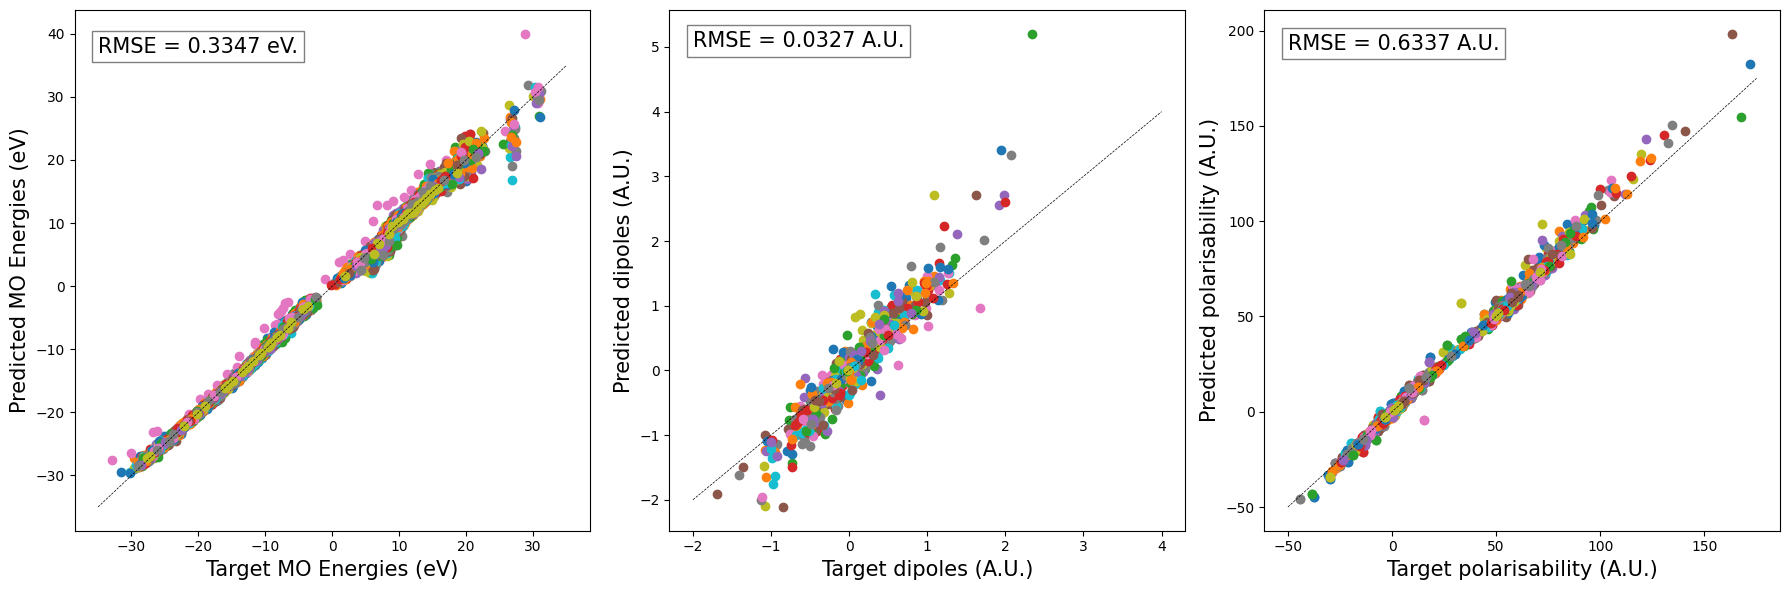

In [121]:
plt.figure()
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot 2: Target vs Predicted MO energies
for target, predicted in zip(test_eva_ref, ridge_eva_pred):
    x = target * Hartree
    y = predicted.detach().numpy() * Hartree
    x = x[x > -100]
    y = y[y > -100]
    axs[0].scatter(x, y)
axs[0].plot([-35, 35], [-35, 35], linestyle='--', color='black', linewidth=0.5)
axs[0].set_xlabel('Target MO Energies (eV)', fontsize=15)
axs[0].set_ylabel('Predicted MO Energies (eV)', fontsize=15)
axs[0].text(-35, 37, f'RMSE = {(torch.sqrt(ridge_error_eva)).item() * Hartree:.4f} eV.', fontsize=15, bbox=dict(facecolor='white', alpha=0.5))

# Plot 2: Target vs Predicted Dipoles
for predicted, target in zip(ridge_dip_pred.detach().numpy(), ml_data_qm9.molecule_data.target["dipole_moment"][ml_data_qm9.train_idx]):
    x = target
    y = predicted
    axs[1].scatter(x,y)
axs[1].plot([-2, 4], [-2, 4], linestyle='--', color='black', linewidth=0.5)
axs[1].set_xlabel('Target dipoles (A.U.)', fontsize=15)
axs[1].set_ylabel('Predicted dipoles (A.U.)', fontsize=15)
axs[1].text(-2, 5, f'RMSE = {(torch.sqrt(ridge_error_dip)).item():.4f} A.U.', fontsize=15, bbox=dict(facecolor='white', alpha=0.5))

# Plot 3: Target vs Predicted Polarisability
for predicted, target in zip(ridge_polar_pred.detach().numpy(), ref_polar[ml_data_qm9.train_idx]):
    x = target
    y = predicted
    axs[2].scatter(x,y)   
axs[2].plot([-50, 175], [-50, 175], linestyle='--', color='black', linewidth=0.5)
axs[2].set_xlabel('Target polarisability (A.U.)', fontsize=15)
axs[2].set_ylabel('Predicted polarisability (A.U.)', fontsize=15)
axs[2].text(-50, 190, f'RMSE = {(torch.sqrt(ridge_error_pol)).item():.4f} A.U.', fontsize=15, bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.savefig("plot_polar_eva/ridge_test_qm9.pdf", bbox_inches='tight')

### load the pre-trained model (on QM7)

In [122]:
model = LinearTargetModel(dataset = ml_data, nlayers = 1, nhidden = 16, bias = False, device = device)
model.load_state_dict(torch.load("model_output_dipole_combined/model_epoch_900.pt"))

<All keys matched successfully>

In [123]:
test_fock_pred_uncoupled = model.forward(
    ml_data_qm9.feat_train, return_type="uncoupled_blocks", batch_indices=ml_data_qm9.train_idx,
)

test_fock_predictions = _to_matrix(test_fock_pred_uncoupled, ml_data_qm9.train_frames, 
                                   ml_data_qm9.train_idx, ml_data_qm9.molecule_data.aux_data["orbitals"])

In [124]:
with io.capture_output() as captured:
    batch_indices = ml_data_qm9.train_idx
    test_dip_pred, test_eva_pred = compute_batch_dipole_moment(
        ml_data_qm9, test_fock_predictions, batch_indices=batch_indices, mfs=all_mfs
    )
    test_polar_pred, test_eva_pred = compute_batch_polarisability(
        ml_data_qm9, test_fock_predictions, batch_indices=batch_indices, mfs=all_mfs
    )

error_dip = mlmetrics.mse_qm7(ml_data_qm9.train_frames,
    test_dip_pred, torch.from_numpy(ml_data_qm9.molecule_data.target["dipole_moment"][batch_indices].astype(np.float64))
)
error_pol = mlmetrics.mse_qm7(ml_data_qm9.train_frames,
    test_polar_pred, torch.from_numpy(ref_polar[batch_indices].astype(np.float64))
)
test_eva_ref = compute_eigvals(ml_data_qm9, [ml_data_qm9.target.tensor[i] for i in batch_indices], batch_indices)
error_eva = mlmetrics.mse_qm7(ml_data_qm9.train_frames, test_eva_pred, test_eva_ref)

In [125]:
print("Test RMSE on polar from indirect learning {:.5f} A.U.".format(torch.sqrt(error_pol).item()))
print("Test RMSE on dipole from indirect learning {:.5f} A.U.".format(torch.sqrt(error_dip).item()))
print("Test RMSE on MO energies from indirect learning {:.5f} eV.".format(torch.sqrt(error_eva).item() * Hartree))

Test RMSE on polar from indirect learning 0.48398 A.U.
Test RMSE on dipole from indirect learning 0.01850 A.U.
Test RMSE on MO energies from indirect learning 0.28483 eV.


<Figure size 640x480 with 0 Axes>

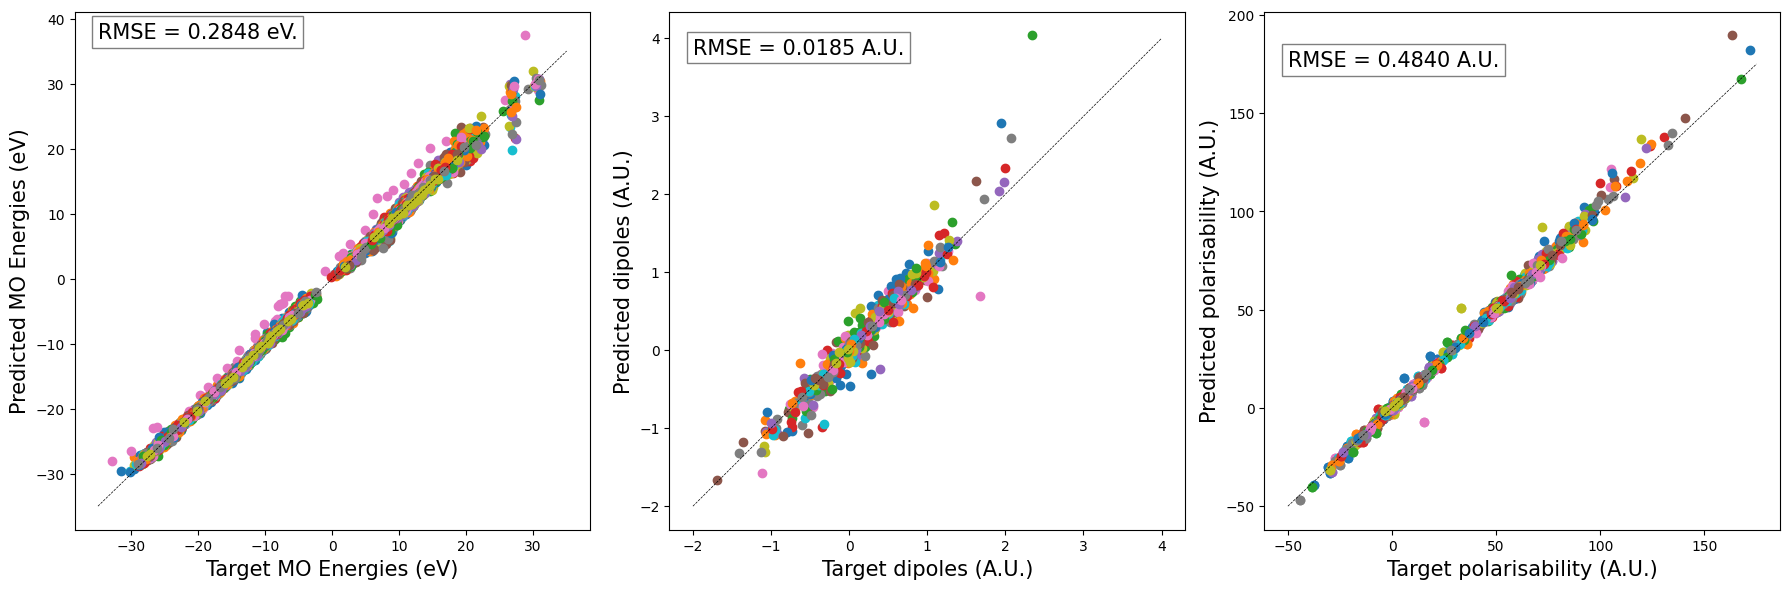

In [127]:
plt.figure()
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot 2: Target vs Predicted MO energies
for target, predicted in zip(test_eva_ref, test_eva_pred):
    x = target * Hartree
    y = predicted.detach().numpy() * Hartree
    x = x[x > -100]
    y = y[y > -100]
    axs[0].scatter(x, y)
axs[0].plot([-35, 35], [-35, 35], linestyle='--', color='black', linewidth=0.5)
axs[0].set_xlabel('Target MO Energies (eV)', fontsize=15)
axs[0].set_ylabel('Predicted MO Energies (eV)', fontsize=15)
axs[0].text(-35, 37, f'RMSE = {(torch.sqrt(error_eva)).item() * Hartree:.4f} eV.', fontsize=15, bbox=dict(facecolor='white', alpha=0.5))

# Plot 2: Target vs Predicted Dipoles
for predicted, target in zip(test_dip_pred.detach().numpy(), ml_data_qm9.molecule_data.target["dipole_moment"][ml_data_qm9.train_idx]):
    x = target
    y = predicted
    axs[1].scatter(x,y)
axs[1].plot([-2, 4], [-2, 4], linestyle='--', color='black', linewidth=0.5)
axs[1].set_xlabel('Target dipoles (A.U.)', fontsize=15)
axs[1].set_ylabel('Predicted dipoles (A.U.)', fontsize=15)
axs[1].text(-2, 3.8, f'RMSE = {(torch.sqrt(error_dip)).item():.4f} A.U.', fontsize=15, bbox=dict(facecolor='white', alpha=0.5))

# Plot 3: Target vs Predicted Polarisability
for predicted, target in zip(test_polar_pred.detach().numpy(), ref_polar[ml_data_qm9.train_idx]):
    x = target
    y = predicted
    axs[2].scatter(x,y)   
axs[2].plot([-50, 175], [-50, 175], linestyle='--', color='black', linewidth=0.5)
axs[2].set_xlabel('Target polarisability (A.U.)', fontsize=15)
axs[2].set_ylabel('Predicted polarisability (A.U.)', fontsize=15)
axs[2].text(-50, 174, f'RMSE = {(torch.sqrt(error_pol)).item():.4f} A.U.', fontsize=15, bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.savefig("plot_dipole_eva/test_qm9.pdf", bbox_inches='tight')